# Simulating the Heston Model in Python

## 1. Introduction and Motivation
The classic Black-Scholes-Merton (BSM) model introduced to most of us as 1st year finance students assumes constant volatility, a simplification that often fails to capture empirical phenomena observed in financial markets, such as volatility clustering, leverage effects, and heavy tails in return distributions. To address these shortcomings, **Steven Heston (1993)** introduced a stochastic volatility framework where volatility evolves randomly over time according to a mean-reverting square-root process (a Cox-Ingersoll-Ross process).

In this notebook, I intend to implement the Heston model and compare it to the BSM model in a simulation-based setting. Specifically, I use Monte Carlo simulation to estimate European option prices and analyze the distributional characteristics of asset paths under both models. The goal is to empirically explore how stochastic volatility impacts option valuation and the dynamics of asset prices.

While this approach provides flexibility and generality, it also introduces numerical challenges, such as ensuring the variance remains non-negative. Additionally, since the Heston model does not admit a closed-form solution for path-dependent derivatives, simulation is a key tool/requirement for analysis.

## 2. Model Parameters and Assumptions
The Heston model assumes the following stochastic differential equations (SDEs):

$$ dS_t = r S_t dt + \sqrt{V_t} S_t dW_t^{(1)} $$
$$ dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^{(2)} $$

where:
- $S_t$ is the asset price
- $V_t$ is the variance (square of volatility)
- $r$ is the risk-free rate
- $\kappa$ is the speed of mean reversion
- $\theta$ is the long-term mean variance
- $\sigma$ is the volatility of volatility
- $\rho$ is the correlation between the Brownian motions $W^{(1)}$ and $W^{(2)}$

We discretize these equations using the Euler-Maruyama method, taking care to enforce the Feller condition ($2\kappa\theta > \sigma^2$) only heuristically by truncating negative variances to zero. This is a known limitation of naive Euler schemes, as discussed in Lord et al. (2010).


## 3. Simulation Strategy
Monte Carlo simulation is used to generate asset and variance paths. For the Heston model, two correlated Brownian motions are required. For comparison, I simulate a corresponding Black-Scholes path using the average volatility obtained from the Heston paths. This offers a baseline for understanding the pricing bias introduced by assuming constant volatility.

## 4. Option Pricing via Monte Carlo
European call options are priced by computing the discounted expectation of the payoff at maturity. Although the Heston model admits a semi-closed-form solution for European options (via characteristic functions and Fourier inversion), this notebook deliberately uses a Monte Carlo approach to maintain consistency with path simulation. This method can easily be extended to exotic options where no closed-form pricing exists.

## 5. Sample Path Visualization
To gain intuition about the stochastic behavior of the asset and variance, a single simulation path is plotted. This path reflects how variance fluctuates and how that in turn affects the asset price. Such visualizations are useful for validating model dynamics and spotting potential numerical issues.

## 6. Terminal Price Distributions
The terminal distribution of asset prices under both models is visualized using histograms. The Heston model typically produces heavier tails and potential skewness in the distribution, important for pricing far out-of-the-money options. This is one of the model’s strengths compared to the log-normality imposed by Black-Scholes. However, the quality of simulation results is sensitive to parameter choices and the discretization scheme used.

## 7. Conclusion and Further Considerations
The results highlight the flexibility of the Heston model in capturing richer asset dynamics and more realistic option prices. However, it comes at the cost of added computational complexity and numerical stability concerns. For further work, calibration to market data would be essential to validate the model's practical effectiveness.

Relevant literature includes:
- Heston, S. L. (1993). *A Closed-Form Solution for Options with Stochastic Volatility*. Review of Financial Studies.
- Lord, R., et al. (2010). *A Comparison of Biased Simulation Schemes for Stochastic Volatility Models*. Quantitative Finance.

While this notebook serves as a useful sandbox, production use would require more sophisticated discretization schemes (e.g. Quadratic-Exponential), calibration routines, and variance reduction techniques.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

params = {
    "S0": 100.0,
    "V0": 0.04,
    "r": 0.05,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.5,
    "rho": -0.7,
    "T": 1.0,
    "N": 252,
    "M": 10000
}

In [2]:
def simulate_heston(params):
    dt = params["T"] / params["N"]
    S = np.zeros((params["M"], params["N"] + 1))
    V = np.zeros((params["M"], params["N"] + 1))
    S[:, 0] = params["S0"]
    V[:, 0] = params["V0"]

    for t in range(1, params["N"] + 1):
        Z1 = np.random.normal(size=params["M"])
        Z2 = np.random.normal(size=params["M"])
        W1 = Z1
        W2 = params["rho"] * Z1 + np.sqrt(1 - params["rho"]**2) * Z2

        V_prev = np.maximum(V[:, t-1], 0)
        V[:, t] = V[:, t-1] + params["kappa"] * (params["theta"] - V_prev) * dt +                   params["sigma"] * np.sqrt(V_prev) * np.sqrt(dt) * W2
        V[:, t] = np.maximum(V[:, t], 0)

        S[:, t] = S[:, t-1] * np.exp((params["r"] - 0.5 * V_prev) * dt + np.sqrt(V_prev * dt) * W1)

    return S, V

def simulate_black_scholes(params, sigma_bs):
    dt = params["T"] / params["N"]
    S = np.zeros((params["M"], params["N"] + 1))
    S[:, 0] = params["S0"]

    for t in range(1, params["N"] + 1):
        Z = np.random.normal(size=params["M"])
        S[:, t] = S[:, t-1] * np.exp((params["r"] - 0.5 * sigma_bs**2) * dt + sigma_bs * np.sqrt(dt) * Z)

    return S

def price_european_option_mc(S_paths, K, r, T, option_type="call"):
    if option_type == "call":
        payoff = np.maximum(S_paths[:, -1] - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - S_paths[:, -1], 0)
    else:
        raise ValueError("Invalid option type")
    return np.exp(-r * T) * np.mean(payoff)

In [3]:
S_heston, V_heston = simulate_heston(params)
avg_vol = np.sqrt(np.mean(V_heston[:, 1:]))
S_bs = simulate_black_scholes(params, sigma_bs=avg_vol)

K = 100
option_price_heston = price_european_option_mc(S_heston, K, params["r"], params["T"])
option_price_bs = price_european_option_mc(S_bs, K, params["r"], params["T"])

print(f"Heston Option Price: {option_price_heston:.4f}")
print(f"Black-Scholes Option Price: {option_price_bs:.4f}")
print(f"Average Volatility used in BS: {avg_vol:.5f}")

Heston Option Price: 10.1641
Black-Scholes Option Price: 10.4842
Average Volatility used in BS: 0.20072


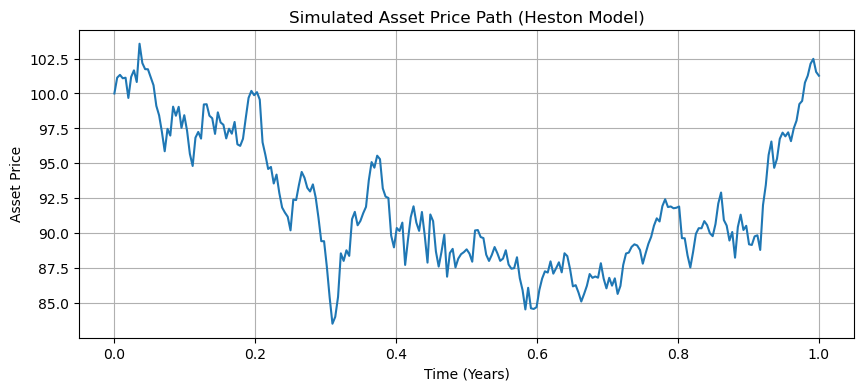

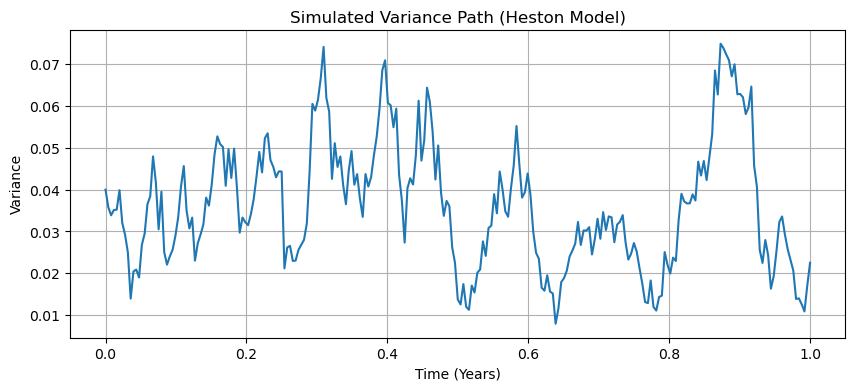

In [4]:
import matplotlib.pyplot as plt

random_path = np.random.randint(0, params["M"])
time_grid = np.linspace(0, params["T"], params["N"] + 1)

plt.figure(figsize=(10, 4))
plt.plot(time_grid, S_heston[random_path])
plt.title("Simulated Asset Price Path (Heston Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Asset Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(time_grid, V_heston[random_path])
plt.title("Simulated Variance Path (Heston Model)")
plt.xlabel("Time (Years)")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

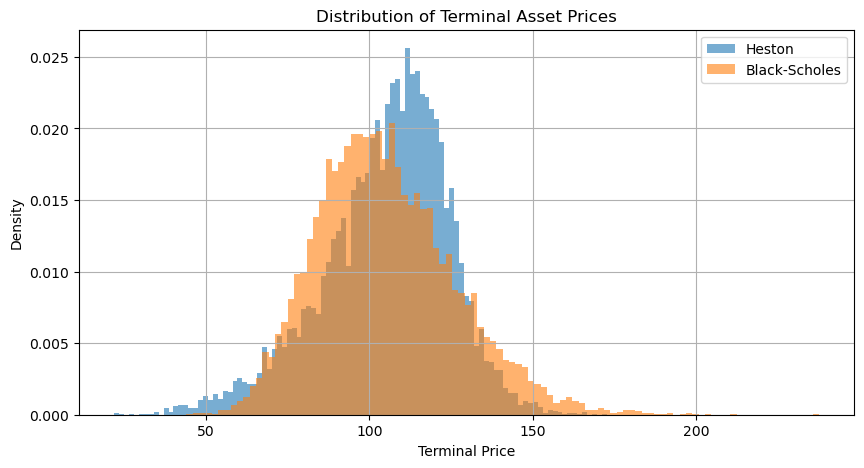

In [5]:
plt.figure(figsize=(10, 5))
plt.hist(S_heston[:, -1], bins=100, alpha=0.6, label="Heston", density=True)
plt.hist(S_bs[:, -1], bins=100, alpha=0.6, label="Black-Scholes", density=True)
plt.title("Distribution of Terminal Asset Prices")
plt.xlabel("Terminal Price")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()